# Find the optimum Rotation of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS, France
- date   : May 29th 2017


- The goal is to rotate the image correctly such the dispersive axis must be parallel to X.
Carefull check must be done with eye such the fit of the Y vs X line is correct without bias.
This can be done on every image. Another solution is to force the value of the rotation angle
if one is sure of it.
- So One must decide if he want one average rotation angle or one rotation angle for each image.
Not sure.

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [10]:
print theNotebook

FindOptRot


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [12]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [13]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [14]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [15]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [16]:
%load_ext Cython

In [17]:
from IPython.display import Image, display

In [18]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [19]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [20]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [21]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [22]:
ensure_dir(dir_top_images) # create that directory

### input directory of fits images

In [23]:
inputdir="./cut_fitsimages"
object_name='HD11190 May 28th 2017'
MIN_IMGNUMBER=16
MAX_IMGNUMBER=25
SelectTagRe='^cutimg_20170528_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170528_[0-9]+.fits$'
NBIMGPERROW=4 # picture printout format

### output directory of fits images

In [24]:
#outputdir="./spectrum_fitsimages"
outputdir="./rotated_fitsimages"

In [25]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [26]:
input_filelist=os.listdir(inputdir) 

In [27]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [28]:
print input_filelist

['cutimg_20170528_016.fits' 'cutimg_20170528_017.fits'
 'cutimg_20170528_018.fits' 'cutimg_20170528_019.fits'
 'cutimg_20170528_020.fits' 'cutimg_20170528_021.fits'
 'cutimg_20170528_022.fits' 'cutimg_20170528_023.fits'
 'cutimg_20170528_024.fits' 'cutimg_20170528_025.fits']


In [29]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [30]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

    


In [31]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [32]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [33]:
print indexes_files

[16 17 18 19 20 21 22 23 24 25]


In [34]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [35]:
sorted_numbers=indexes_files[sorted_indexes]

In [36]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [37]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [38]:
#sorted_files

## Build full filename
----------------------------

In [39]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [40]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [41]:
print sorted_filenames.shape

(10,)


## Acces to data of  images
----------------------------------

In [42]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []

In [43]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo

In [44]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [45]:
len(all_images)

10

In [46]:
NBIMGPERROW

4

In [104]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

global NBIMGPERROW
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=-10,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Images of '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)  
    return thex0

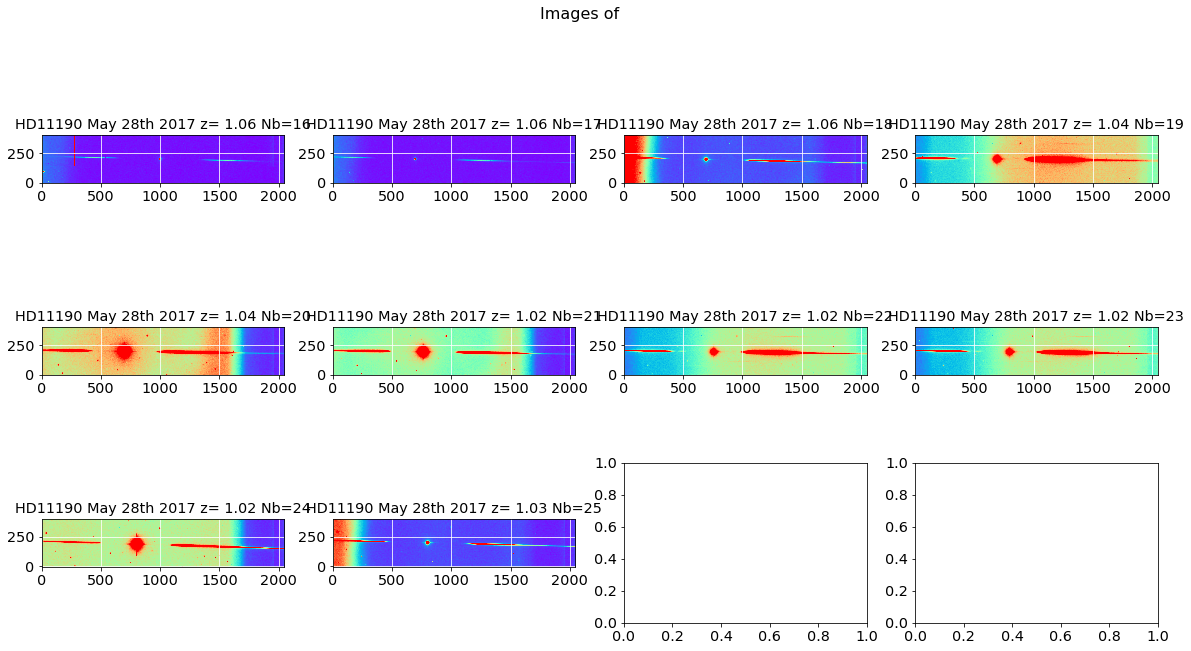

In [105]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

### Shows the transverse profile

In [49]:
DeltaX=600
w=20
ws=80

In [50]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
import os


def ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    DeltaX=600
    w=20
    ws=80
    thespectra= []
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,15))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])
        data[:,DeltaX-ws:DeltaX+ws]=0
        if(all_expo[index]<=0):
            yprofile=np.sum(data,axis=1)  #very special case
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        axarr[iy,ix].set_ylim(1000.,2e5)
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)
        thespectra.append(xprofile/(2.*float(w))/all_expo[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    return thespectra,they0

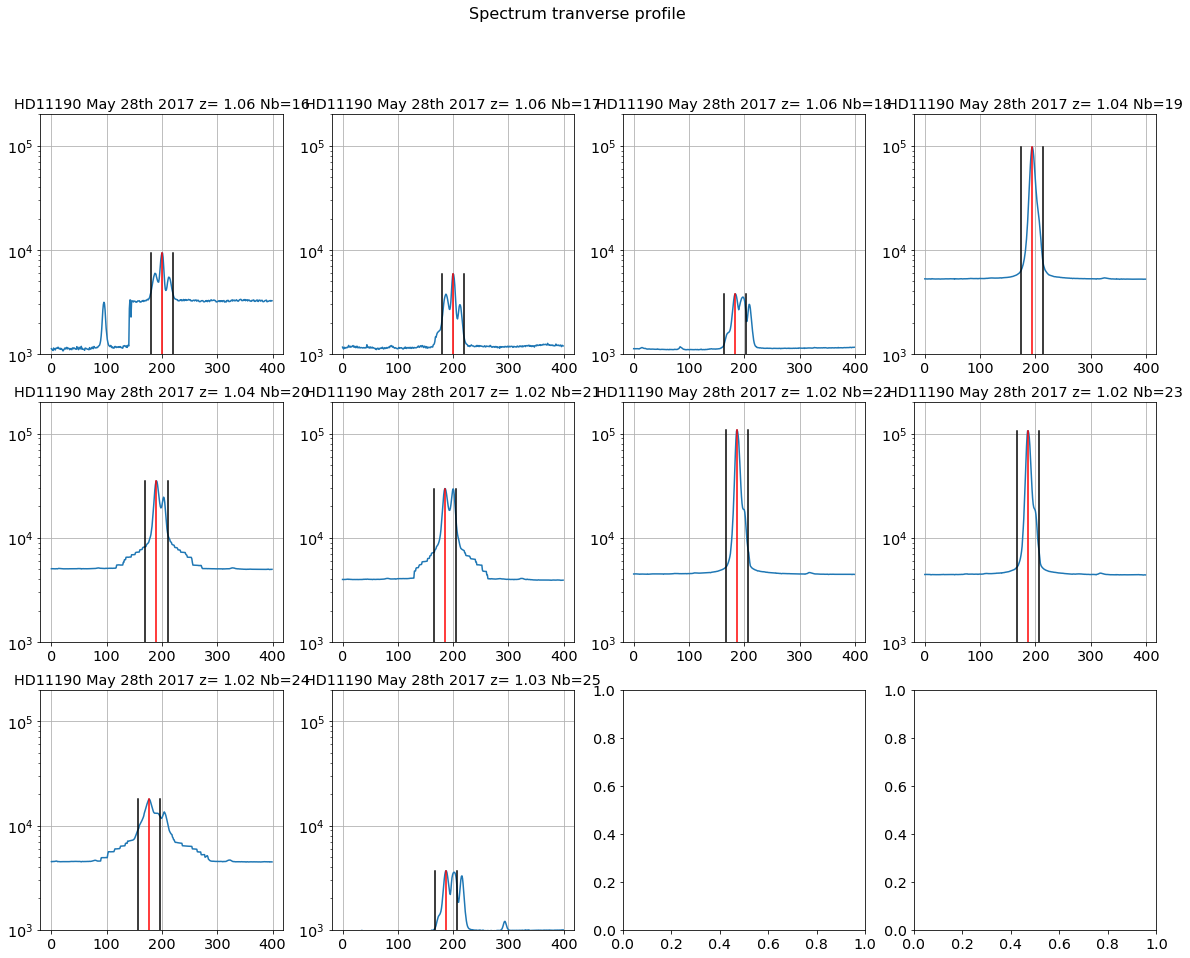

In [51]:
thespectra,they0=ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images)

In [52]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,15))
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,200.)
    title='Spectrum 1D profile '.format(object_name)
    figfilename=os.path.join(dir_top_images,'longitudinal_profile.pdf')
    plt.savefig(figfilename)  
    plt.suptitle(title,size=16)

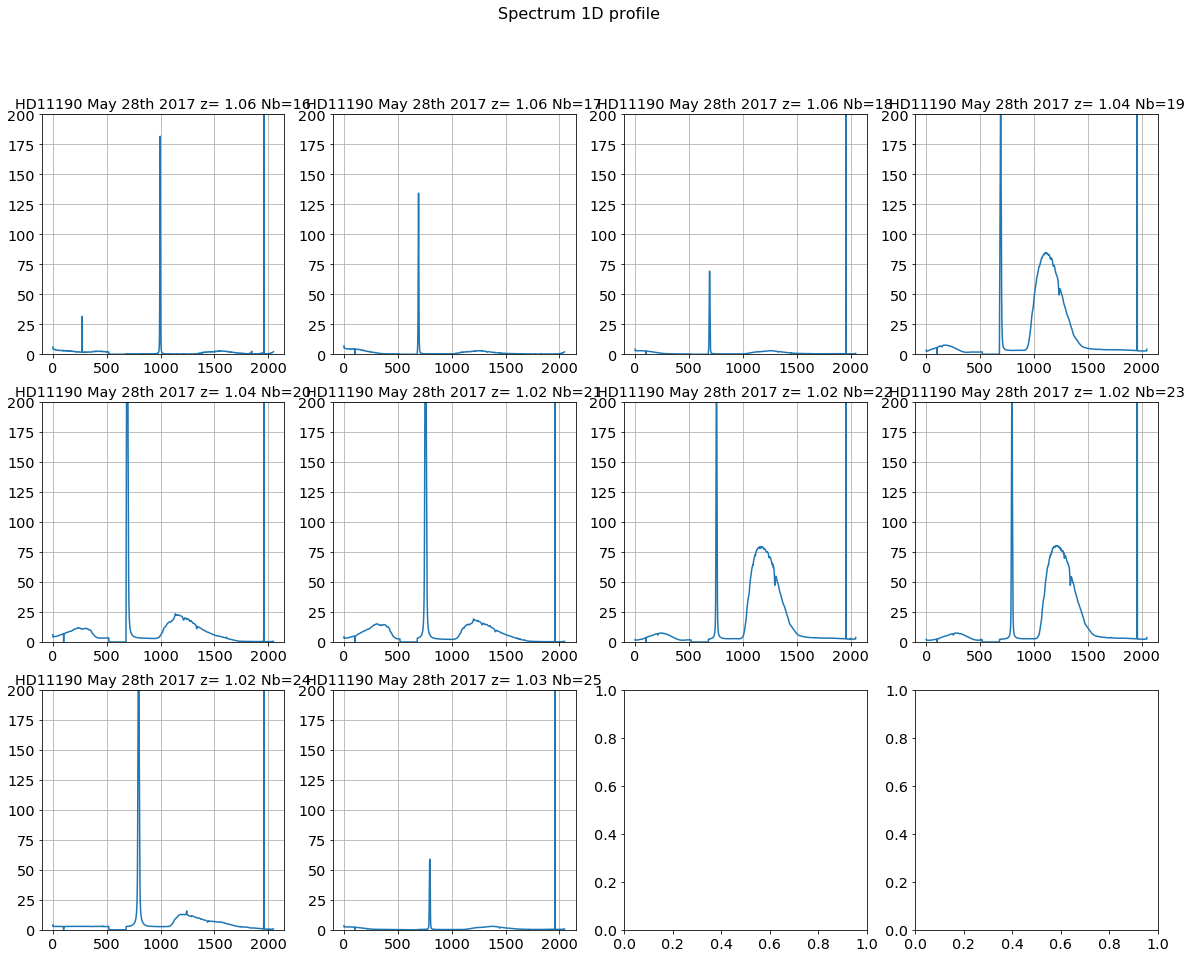

In [53]:
ShowSpectrumProfile(thespectra,all_titles,object_name,dir_top_images)

In [54]:
print they0

[200, 200, 184, 194, 190, 185, 187, 187, 177, 187]


In [55]:
print thex0

[1958, 692, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958]


### Test rotation optimum
----------------------------

In [56]:
from scipy import stats 
from scipy import ndimage
from scipy.optimize import curve_fit

In [57]:
sel=1

In [58]:
image_sel=np.copy(all_images[sel])
y0=they0[sel]
x0=thex0[sel]

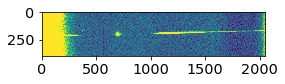

In [59]:
plt.imshow(image_sel,vmin=-10,vmax=50)

In [60]:
region=np.copy(image_sel[y0-100:y0+100,:])
data=np.copy(region)

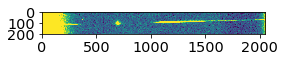

In [61]:
plt.imshow(data,vmin=-10,vmax=50)

### find the orientation by the average

In [62]:
def ComputeMedY(data):
    """
    Compute the median of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_medianY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_medianY[ix]=med
    return the_medianY

In [63]:
def ComputeAveY(data):
    """
    Compute the average of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_averY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_averY[ix]=med
    return the_averY

In [64]:

xindex=np.arange(data.shape[1])

In [65]:
#selected_indexes=np.where(np.logical_or(xindex<480,xindex>1100))

In [66]:
selected_indexes=np.where(np.logical_and(np.logical_or(xindex<430,xindex>1150),xindex< 1440))

In [67]:
yaver=ComputeAveY(data)

In [68]:
XtoFit=xindex[selected_indexes]
YtoFit=yaver[selected_indexes]

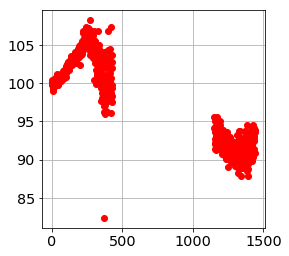

In [69]:
plt.plot(XtoFit,YtoFit,'ro')
#plt.ylim(80,120)
plt.grid(True)

In [70]:
def fit_func(x, a, b):
    return a*x + b

In [71]:
from scipy.optimize import curve_fit
   

In [72]:
params = curve_fit(fit_func, XtoFit, YtoFit)
[a, b] = params[0]

In [73]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)

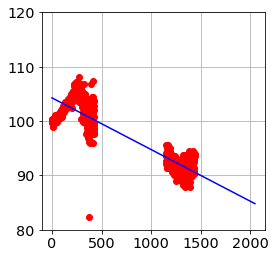

In [74]:
plt.plot(XtoFit,YtoFit,'ro')
plt.plot(x_new,y_new,'b-')
plt.ylim(80,120)
plt.grid(True)

In [75]:
print a,b

-0.00950526043363 104.271231568


In [76]:
print np.arctan(a)*180/np.pi

-0.544594905036


## Find Rotation angle for each image
----------------------------------------------

In [77]:
def ComputeRotationAnge(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAnge
    ===================
    
    input:
    ------
    all_images
    thex0
    they0
    
    
    output:
    ------
    param_a
    param_b
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    param_a=np.zeros(NBIMAGES)
    param_b=np.zeros(NBIMAGES)

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,20))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-100:y0+100,:])
        data=np.copy(region)
        
        xindex=np.arange(data.shape[1])
        #selected_indexes=np.where(np.logical_or(xindex<480,xindex>1100))
        #selected_indexes=np.where(np.logical_and(np.logical_or(xindex<450,xindex>1100),xindex< 1500))
        selected_indexes=np.where(np.logical_and(np.logical_or(xindex<430,xindex>1150),xindex< 1440))
        # compute Y vs X
        yaver=ComputeAveY(data)
        
        XtoFit=xindex[selected_indexes]
        YtoFit=yaver[selected_indexes]
        # does the fit
        params = curve_fit(fit_func, XtoFit, YtoFit)
        [a, b] = params[0]
        
        param_a[index]=a
        param_b[index]=b
        
        print index,' y = ',a,' * x + ',b
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = fit_func(x_new,a,b)
    
        im=axarr[iy,ix].plot(XtoFit,YtoFit,'ro')
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(80,120)
        axarr[iy,ix].grid(True)
        
    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_a,param_b
    
    

0  y =  -0.00303257366056  * x +  103.397918746
1  y =  -0.00950526043363  * x +  104.271231568
2  y =  -0.00469048305355  * x +  105.204215435
3  y =  -0.00417906222113  * x +  104.378956063
4  y =  -0.00354367649576  * x +  103.610733173
5  y =  -0.00530675364058  * x +  106.691590427
6  y =  -0.00471228748151  * x +  105.616962618
7  y =  -0.00446349336705  * x +  105.496624022
8  y =  -0.00335837664281  * x +  103.979849117
9  y =  -0.0057513148665  * x +  109.189346162


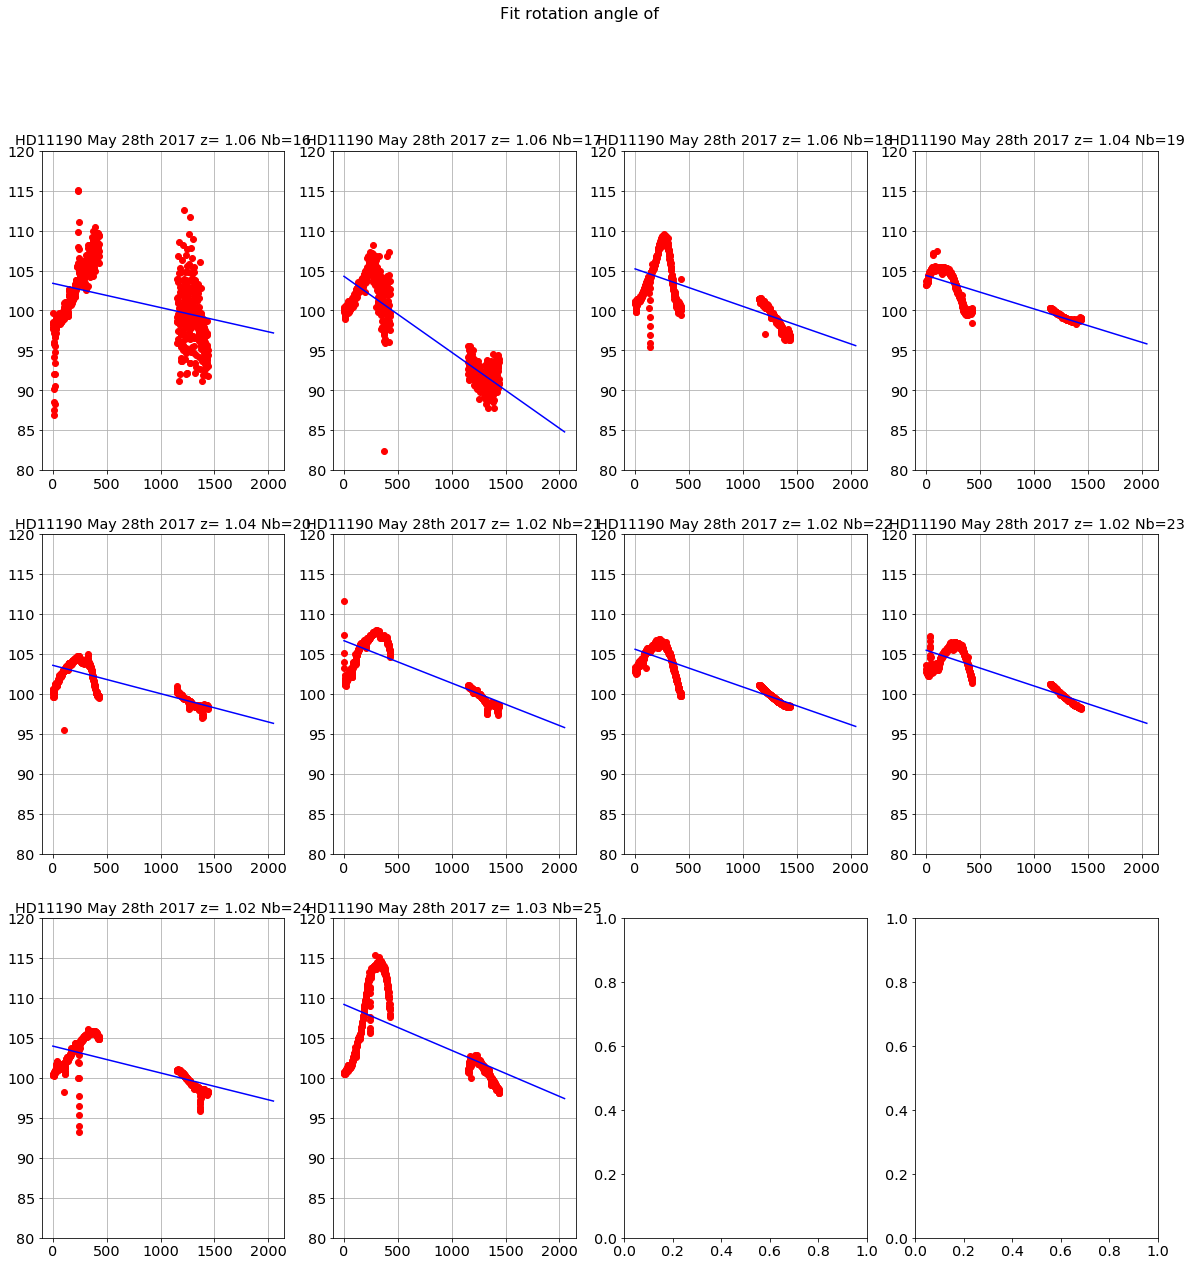

In [78]:
all_a,all_b=ComputeRotationAnge(all_images,thex0,they0,all_titles,object_name)

In [79]:
all_angles=np.arctan(all_a)*180./np.pi

### Choose here which rotation angle to apply

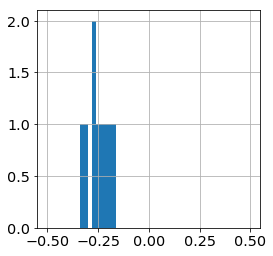

In [80]:
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
n, bins, patches=plt.hist(all_angles,bins=50,range=[-.5,.5],histtype='stepfilled')
plt.grid(True)

In [81]:
selected_angles=all_angles[np.where(all_angles<0)]

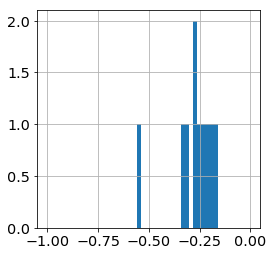

In [82]:
n, bins, patches=plt.hist(selected_angles,bins=50,range=[-1.,0],histtype='stepfilled')
plt.grid(True)

In [83]:
rotation_average=selected_angles.mean()

#### Choose here if we want one average angle or one angle per image.
-J'ai choisi ci-dessous de mettre à la main une rotation de -1.3 degrés

In [84]:
final_rotation_angles=np.ones(all_angles.shape[0])*(-1.3)

In [85]:
#final_rotation_angles=all_angles  # I select individual rotation, one per image

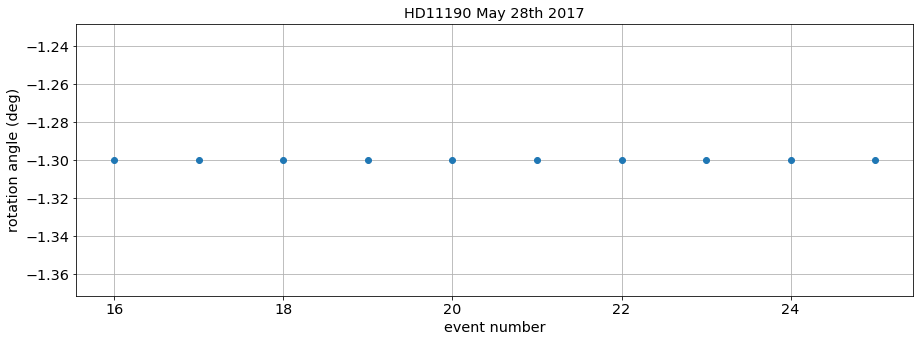

In [86]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,final_rotation_angles,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum.pdf')
plt.savefig(figfilename) 

## Now turn the images accordingly

In [106]:
def TurnTheImages(all_images,all_angles,all_titles,object_name,dir_top_images):
    """
    TurnTheImages
    =============
    
    input:
    ------
    all_images:
    all_angles:
    
    
    output:
    ------
    all_rotated_images
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    all_rotated_images = []

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(20,10))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        angle=all_angles[index]    
        data=np.copy(image)
        
        rotated_image=ndimage.interpolation.rotate(data,angle)
        
        all_rotated_images.append(rotated_image)
        
        im=axarr[iy,ix].imshow(rotated_image,origin='lower',cmap='rainbow',vmin=0,vmax=800)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        
        axarr[iy,ix].grid(True)
        
    title='Rotated images for '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
    plt.savefig(figfilename)  
    
    return all_rotated_images

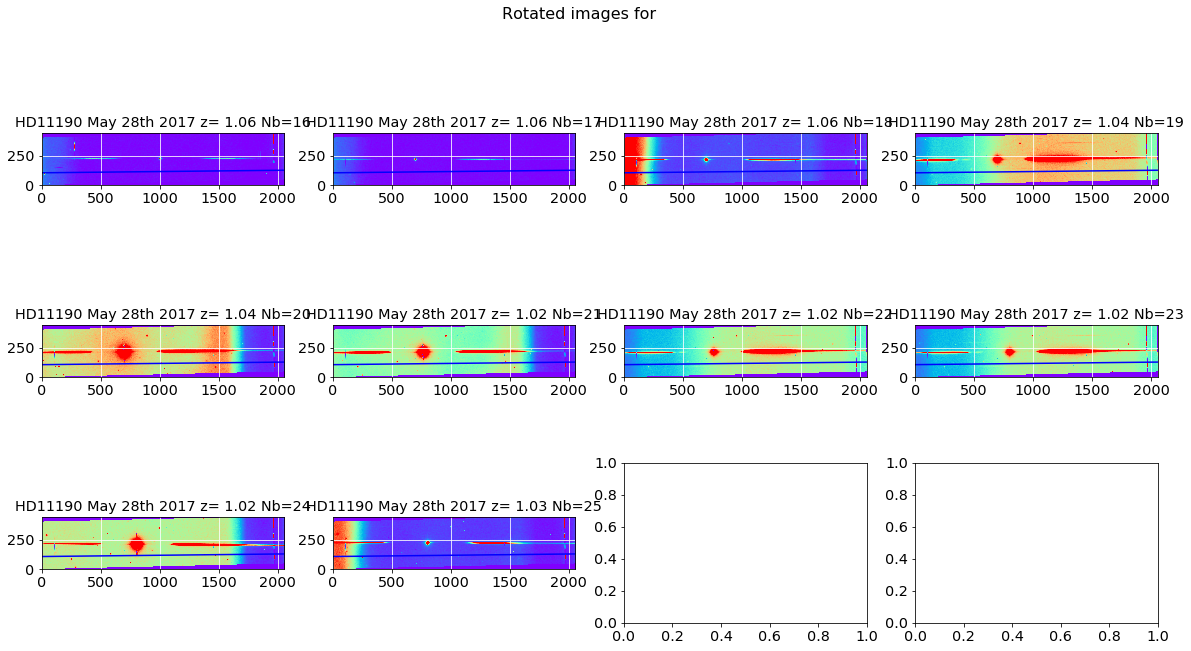

In [107]:
#turned_images=TurnTheImages(all_images,all_angles,all_titles,object_name)
turned_images=TurnTheImages(all_images,final_rotation_angles,all_titles,object_name,dir_top_images) #same rotation for each image

## Check rotation

In case of bad rotation, check by eye

In [89]:
sel=9

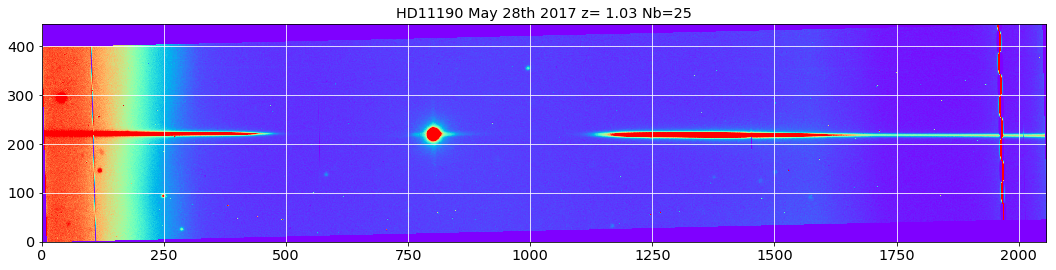

In [108]:
plt.figure(figsize=(18,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=800)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

In [91]:
image_sel=np.copy(turned_images[sel])
y0=they0[sel]
x0=thex0[sel]

In [92]:
region=np.copy(image_sel[y0-100:y0+100,:])
#region[:,500-100:500+100]=0
data=np.copy(region)

In [93]:
xindex=np.arange(data.shape[1])

In [94]:
#selected_indexes=np.where(np.logical_or(xindex<480,xindex>1100))
#selected_indexes=np.where(np.logical_and(np.logical_or(xindex<460,xindex>1100),xindex< 1500))
selected_indexes=np.where(np.logical_and(np.logical_or(xindex<440,xindex>1150),xindex< 1440))

In [95]:
yaver=ComputeAveY(data)

In [96]:
XtoFit=xindex[selected_indexes]
YtoFit=yaver[selected_indexes]

In [97]:
params = curve_fit(fit_func, XtoFit, YtoFit)
[a, b] = params[0]

In [98]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)

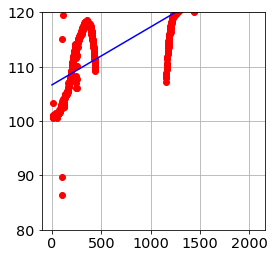

In [99]:
plt.plot(XtoFit,YtoFit,'ro')
plt.plot(x_new,y_new,'b-')
plt.ylim(80,120)
plt.grid(True)

### prepare outputfilename

In [100]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [101]:
newfullfilenames

['./rotated_fitsimages/rotimg_20170528_016.fits',
 './rotated_fitsimages/rotimg_20170528_017.fits',
 './rotated_fitsimages/rotimg_20170528_018.fits',
 './rotated_fitsimages/rotimg_20170528_019.fits',
 './rotated_fitsimages/rotimg_20170528_020.fits',
 './rotated_fitsimages/rotimg_20170528_021.fits',
 './rotated_fitsimages/rotimg_20170528_022.fits',
 './rotated_fitsimages/rotimg_20170528_023.fits',
 './rotated_fitsimages/rotimg_20170528_024.fits',
 './rotated_fitsimages/rotimg_20170528_025.fits']

### Save outputfilename

In [102]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [103]:
!ls -l rotated_fitsimages

total 143680
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_016.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_017.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_018.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_019.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_020.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_021.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_022.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_023.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_024.fits
-rw-r--r--  1 dagoret-campagnesylvie  staff  7352640 May 29 16:19 rotimg_20170528_025.fits
